# TSS Analysis

This notebook will calculate the distance of each ATAC peak to the closest transcription start site (TSS). It will save the results to _data-processed/peaks_annotated.csv_ adding the columns *dist_to_TSS*, *TSS_GeneName*, *is_promoter*, *is_enhancer*, *is_intragenic*, *is_extragenic*.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from scipy.stats import ttest_ind, spearmanr

DATA_DIR = "data/"
DATA_PROC_DIR = "data-processed/"
ATAC_SEQ_PATH = os.path.join(DATA_DIR, "ImmGenATAC18_AllOCRsInfo.csv")
REFFLAT_PATH = os.path.join(DATA_DIR, "refFlat.txt.gz")
PROC_PEAKS_PATH = os.path.join(DATA_PROC_DIR, "peaks_annotated.csv")

# Load ATAC-seq data
atac = pd.read_csv(ATAC_SEQ_PATH, index_col=[0,1,2])
atac.index.names = ["id","chrom","summit"]
peaks = atac.reset_index()
# Load gene annotation data
refFlat = pd.read_csv(REFFLAT_PATH, sep="\t", header=None, compression="gzip")
refFlat.columns = ["geneName", "transcriptName", "chrom", "strand", "tx5p", "tx3p",
    "cdsStart", "cdsEnd", "exonCount", "exonStarts", "exonEnds"]

In [23]:
PROMOTER_CUTOFF = 150  # distance to TSS to be considered a promoter

# Check if pre-processed peaks exist if not generate them
if not os.path.exists(PROC_PEAKS_PATH):
    # Compute TSS for each transcript:
    # If strand == "+", TSS = tx5p; if "-", TSS = tx3p
    refFlat["tss"] = np.where(refFlat["strand"] == "+",
                            refFlat["tx5p"],
                            refFlat["tx3p"])

    # Create per-chromosome list of (tss, geneName, strand) tuples, sorted
    tss_by_chr = {
        chrom: ref_chr[["tss", "geneName", "strand"]].sort_values("tss").values
        for chrom, ref_chr in refFlat.groupby("chrom")
    }

    # === Distance + GeneName function ===
    def nearest_tss_and_gene(chrom, pos):
        if chrom not in tss_by_chr:
            return (np.nan, None)
        entries = tss_by_chr[chrom]
        tss_values = [t[0] for t in entries]
        idx = np.searchsorted(tss_values, pos)

        closest_dist = np.inf
        closest_gene = None

        for candidate_idx in [idx-1, idx]:  # only compare neighbors
            if candidate_idx < 0 or candidate_idx >= len(tss_values):
                continue

            tss = tss_values[candidate_idx]
            gene = entries[candidate_idx][1]
            # Calculate distance bases on strand
            signed_dist = pos - tss if entries[candidate_idx][2] == "+" else tss - pos

            if closest_dist is np.inf or abs(signed_dist) < abs(closest_dist):
                closest_dist = signed_dist
                closest_gene = gene

        return (closest_dist, closest_gene)

    
    # Annotate each peak
    dists = []
    is_promoter = []
    is_intragenic = []
    geneNames = []

    # pre-group gene intervals per chromosome
    genes_by_chr = {c: g[["cdsStart","cdsEnd"]].values for c,g in refFlat.groupby("chrom")}

    for _, row in peaks.iterrows():
        chrom, summit = row["chrom"], row["summit"]

        # distance to nearest TSS
        d, name = nearest_tss_and_gene(chrom, summit)
        dists.append(d)
        geneNames.append(name)

        # promoter if within ±1kb
        is_promoter.append(abs(d) <= PROMOTER_CUTOFF)

        # intragenic if center falls within any gene interval
        intr = False
        for gs, ge in genes_by_chr.get(chrom, []):
            if gs <= summit <= ge:
                intr = True
                break
        is_intragenic.append(intr)

    # attach to peaks DataFrame
    peaks["dist_to_TSS"]   = dists
    peaks["TSS_GeneName"]  = geneNames
    peaks["is_promoter"]   = is_promoter
    peaks["is_enhancer"]   = ~peaks["is_promoter"]
    peaks["is_intragenic"] = is_intragenic
    peaks["is_extragenic"] = ~peaks["is_intragenic"]

    # Save annotated peaks
    os.makedirs(DATA_PROC_DIR, exist_ok=True) # Ensure directory exists
    peaks.to_csv(PROC_PEAKS_PATH, index=False)
else: # Otherwise load pre-processed peaks
    peaks = pd.read_csv(PROC_PEAKS_PATH)

In [24]:
# Compute per‐cell stats
peaks["mean_access"] = atac.mean(axis=1, numeric_only=True).values
peaks["var_access"]  = atac.var(axis=1, numeric_only=True).values
peaks["cv_access"]   = atac.std(axis=1, numeric_only=True).values / (peaks["mean_access"] + 1e-6)

# --- 3. Filter low-signal / low-variance peaks ---
mean_thr = peaks["mean_access"].quantile(0.05)
var_thr  = peaks["var_access"].quantile(0.05)
filtered = peaks[(peaks["mean_access"] > mean_thr) & (peaks["var_access"] > var_thr)]
print(f"Kept {len(filtered)} / {len(peaks)} peaks (mean>{mean_thr:.2f}, var>{var_thr:.2f})")

# Define dataset we are working with
#dataset = filtered
dataset = peaks

c:\Users\luisw\miniconda3\envs\data_analysis\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\luisw\miniconda3\envs\data_analysis\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Kept 475349 / 512595 peaks (mean>0.87, var>0.68)


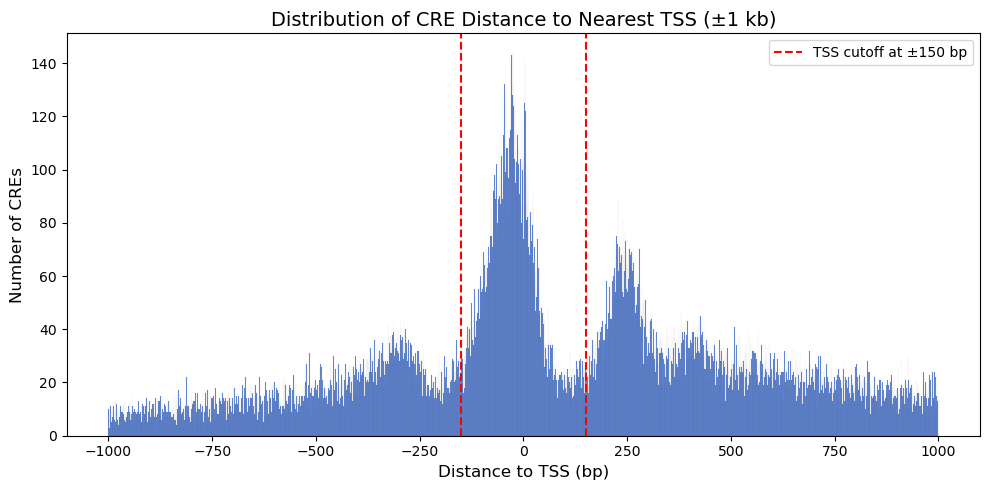

In [27]:
# Plot the distribution of distances to TSS
# Remove NaNs and limit extreme values for better plot scale
distances = dataset["dist_to_TSS"].dropna()
distances = distances[distances.abs() <= 1e3]  # only +/-1 kb

plt.figure(figsize=(10, 5))
sns.histplot(distances, bins=2000, color="#3366cc")

plt.axvline(PROMOTER_CUTOFF, color="red", linestyle="--", label=f"TSS cutoff at ±{PROMOTER_CUTOFF} bp")
plt.axvline(-PROMOTER_CUTOFF, color="red", linestyle="--")
#plt.xlim(-1000, 1000)

plt.title("Distribution of CRE Distance to Nearest TSS (±1 kb)", fontsize=14)
plt.xlabel("Distance to TSS (bp)", fontsize=12)
plt.ylabel("Number of CREs", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

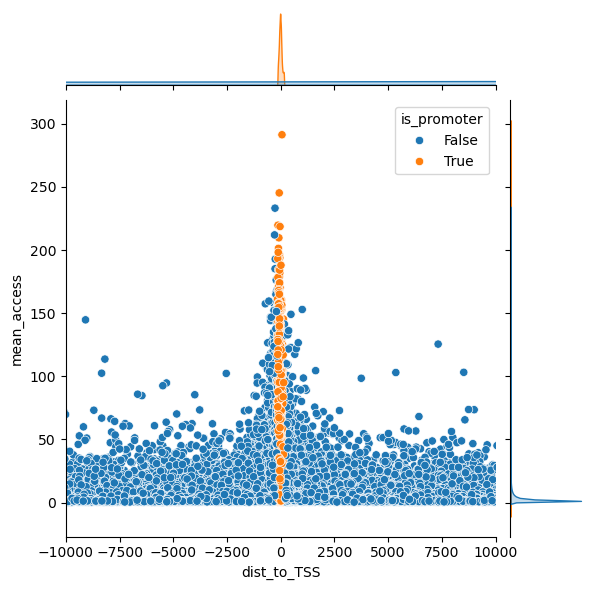

<Figure size 1000x1000 with 0 Axes>

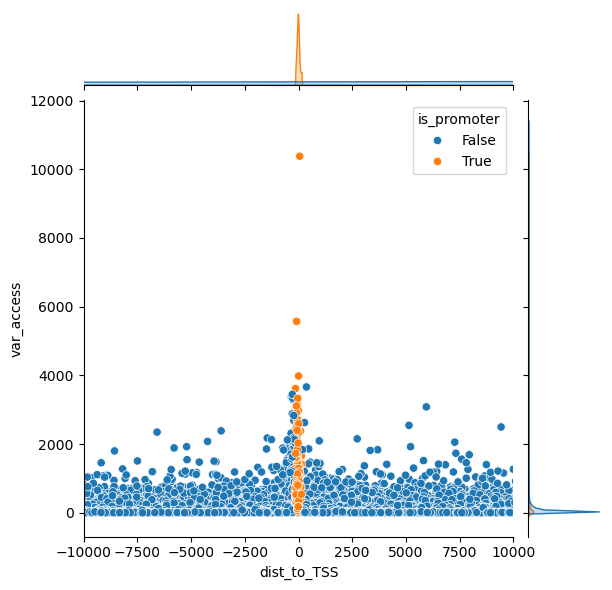

In [28]:
plt.figure(figsize=(10, 10))
sns.jointplot(data=dataset, x="dist_to_TSS", y="mean_access", hue="is_promoter",
              xlim=(-10000, 10000))
plt.show()

plt.figure(figsize=(10, 10))
sns.jointplot(data=dataset, x="dist_to_TSS", y="var_access", hue="is_promoter",
              xlim=(-10000, 10000))
plt.show()

ii. b. Do promoters exibit specific signals that make them differ from enhancers?

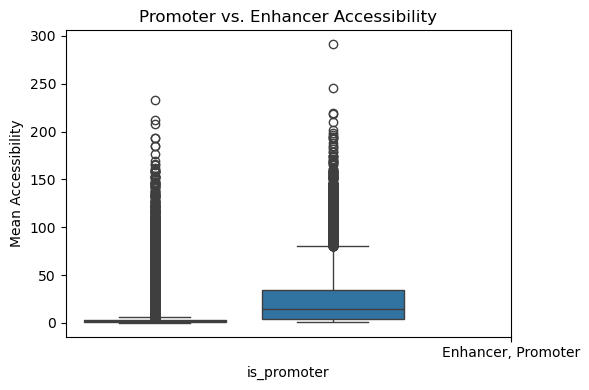

In [29]:
plt.figure(figsize=(6,4))
sns.boxplot(x="is_promoter", y ="mean_access", data=dataset)
plt.xticks(["Enhancer, Promoter"])
plt.ylabel("Mean Accessibility")
plt.title("Promoter vs. Enhancer Accessibility")
plt.tight_layout()
plt.show()

In [30]:
prom_vals = dataset.loc[dataset.is_promoter, "mean_access"].dropna()
enh_vals = dataset.loc[~dataset.is_promoter, "mean_access"].dropna()
# Remove any inf or nan values before t-test
prom_vals_clean = prom_vals[np.isfinite(prom_vals)]
enh_vals_clean = enh_vals[np.isfinite(enh_vals)]
tstat, pval = ttest_ind(prom_vals_clean, enh_vals_clean, equal_var=False)
print(f"Promoter vs Enhancer t-test {tstat:.2f}, p-value: {pval:.2f}")

Promoter vs Enhancer t-test 100.71, p-value: 0.00


<Axes: xlabel='mean_access', ylabel='Count'>

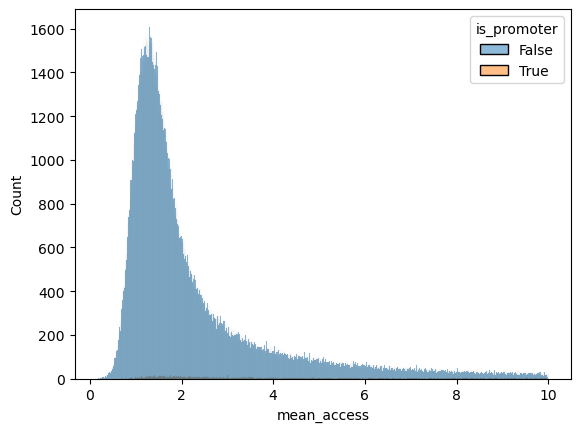

In [31]:
sns.histplot(data=dataset[(dataset["mean_access"] <= 10)],
             x="mean_access", hue="is_promoter", bins=2000)

ii. c. Is there a relationship between the signal and the distance to the TSS?

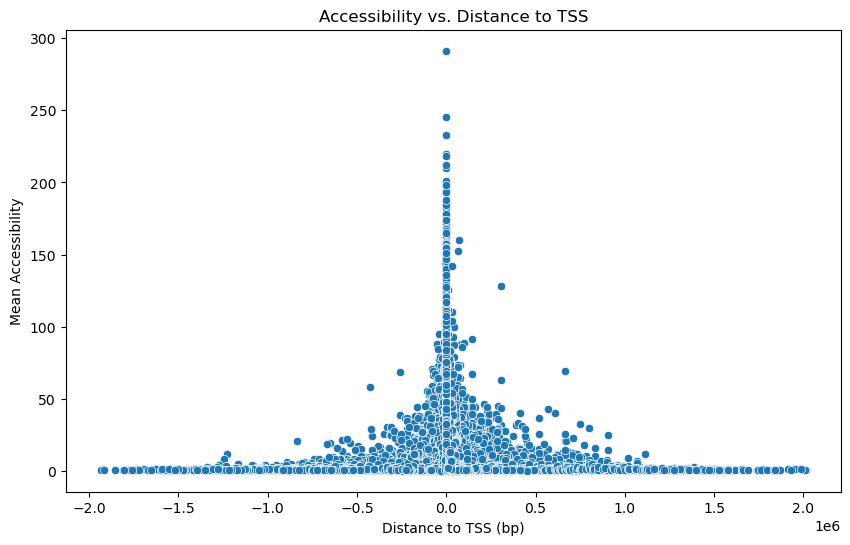

In [32]:
plt.figure(figsize=(10,6)) #TODO Hexaplot 
sns.scatterplot(x="dist_to_TSS", y="mean_access", data=dataset)
plt.xlabel("Distance to TSS (bp)")
plt.ylabel("Mean Accessibility")
plt.title("Accessibility vs. Distance to TSS")
plt.show()

In [33]:
rho, sp_p = spearmanr(dataset["dist_to_TSS"], dataset["mean_access"], nan_policy="omit")
print(f"Spearman rho (access vs dist): {rho:.2f}, p-value: {sp_p:.2f}")

Spearman rho (access vs dist): -0.05, p-value: 0.00


<Figure size 1000x600 with 0 Axes>

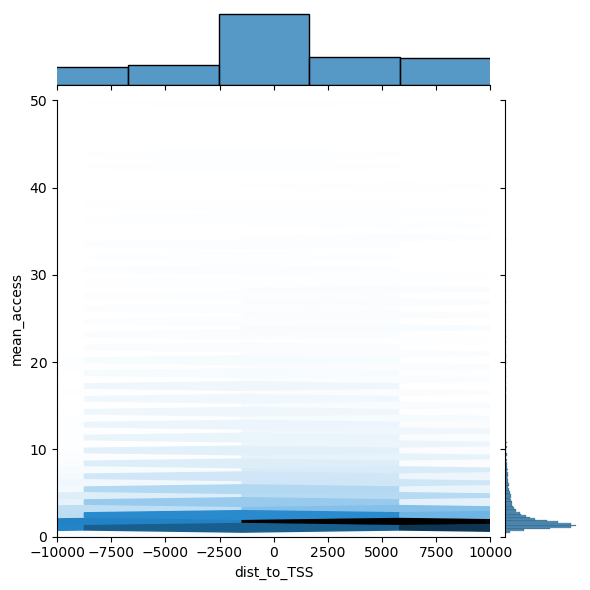

In [34]:
plt.figure(figsize=(10,6))
sns.jointplot(data=dataset.sample(10000), x="dist_to_TSS", y="mean_access", kind="hex", gridsize=200, xlim=(-10000, 10000), ylim=(0, 50))

ii. d. Are intronic enhancers different from enhancers outside the transcript.

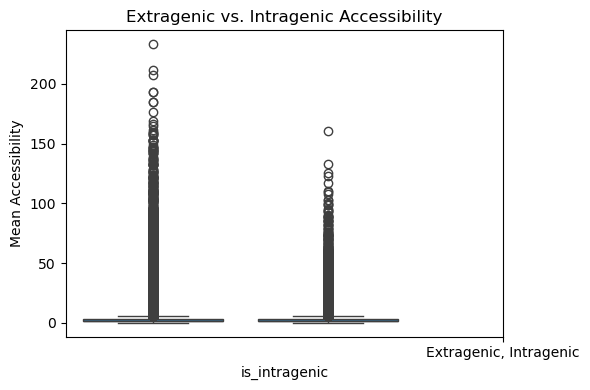

In [35]:
enhancers = dataset[~dataset.is_promoter]

plt.figure(figsize=(6,4))
sns.boxplot(x="is_intragenic", y ="mean_access", data=enhancers)
plt.xticks(["Extragenic, Intragenic"])
plt.ylabel("Mean Accessibility")
plt.title("Extragenic vs. Intragenic Accessibility")
plt.tight_layout()
plt.show()

In [36]:
intra = enhancers.loc[enhancers.is_intragenic, "mean_access"]
extra = enhancers.loc[~enhancers.is_intragenic, "mean_access"]
# Remove any inf or nan values before t-test
intra_vals_clean = intra[np.isfinite(intra)]
extra_vals_clean = extra[np.isfinite(extra)]
tstat2, pval2 = ttest_ind(intra_vals_clean, extra_vals_clean, equal_var=False)
print(f"Intragenic vs Extragenic t-test {tstat2}, p-value: {pval2}")

Intragenic vs Extragenic t-test -24.965492112034557, p-value: 1.7699848927400539e-137


<Axes: xlabel='mean_access', ylabel='Count'>

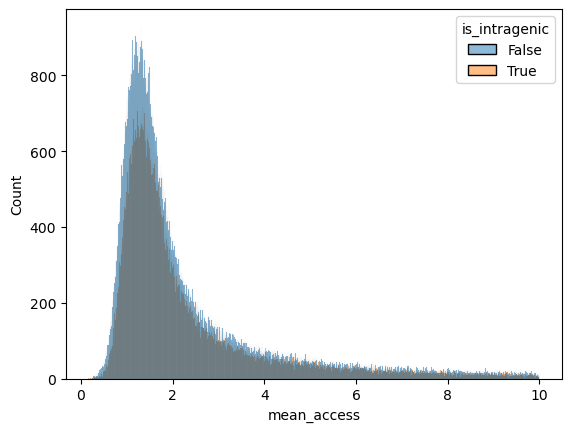

In [37]:
sns.histplot(data=enhancers[(enhancers["mean_access"] <= 10)],
             x="mean_access", hue="is_intragenic", bins=2000)

<Figure size 1000x1000 with 0 Axes>

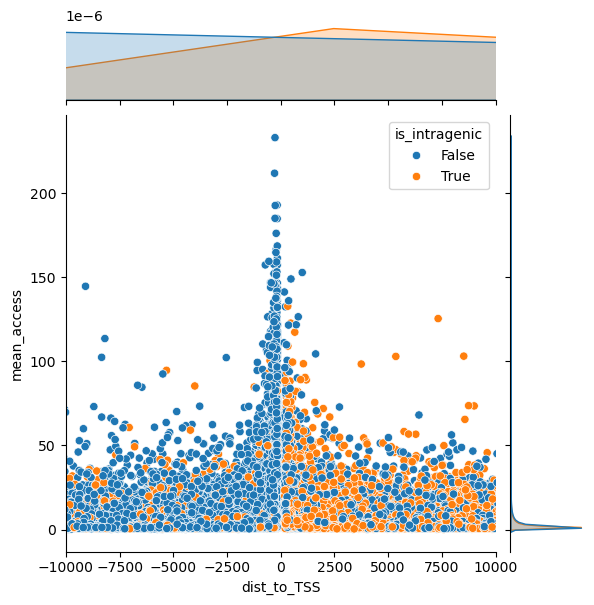

<Figure size 1000x1000 with 0 Axes>

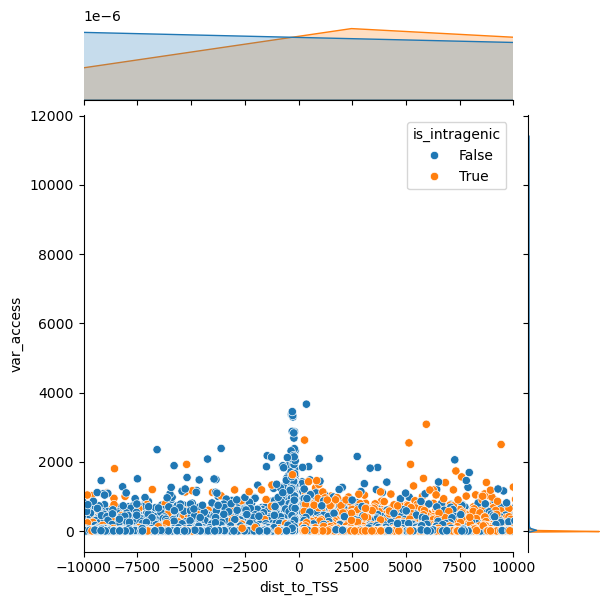

In [38]:
plt.figure(figsize=(10, 10))
sns.jointplot(data=enhancers, x="dist_to_TSS", y="mean_access", hue="is_intragenic",
              xlim=(-10000, 10000))
plt.show()

plt.figure(figsize=(10, 10))
sns.jointplot(data=enhancers, x="dist_to_TSS", y="var_access", hue="is_intragenic",
              xlim=(-10000, 10000))
plt.show()


<Figure size 1000x1000 with 0 Axes>

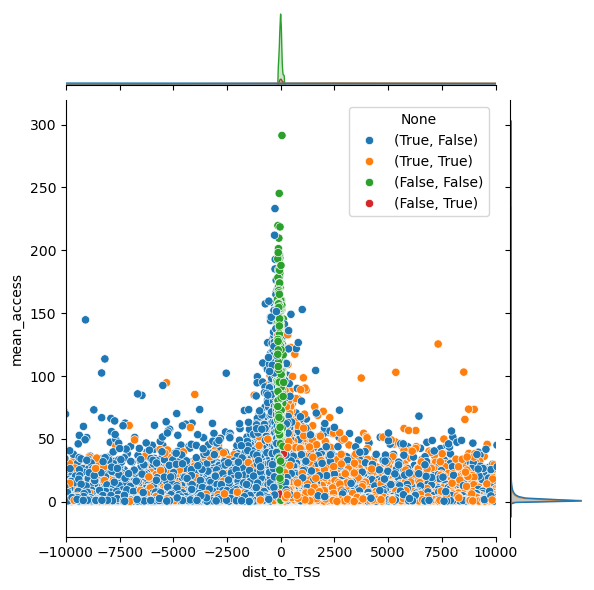

In [39]:
plt.figure(figsize=(10, 10))
sns.jointplot(data=dataset, x="dist_to_TSS", y="mean_access", hue=dataset[['is_enhancer', 'is_intragenic']].apply(tuple, axis=1),
              xlim=(-10000, 10000))
plt.show()
